In [ ]:
import multimodal_cci as mmcci
import scanpy as sc

#### Load stLearn data objects

In [2]:
brain_a_vis = [sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1C_CCI.h5ad"),
                sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1D_CCI.h5ad"),
                sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1B_CCI.h5ad"),
                sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1D_CCI.h5ad")]
brain_y_vis = [sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1A_CCI.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP40_1B_CCI.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1A_CCI.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/Visium/Processed/Brain/CCI/VLP41_1C_CCI.h5ad")]

brain_a_sto = [sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A1_CCI_bin80.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_A4_CCI_bin80.h5ad")]
brain_y_sto = [sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y1_CCI_bin80.h5ad"),
               sc.read_h5ad("/QRISdata/Q5058/sMACS/STomics/Processed/Brain/CCI_new/brain_Y4_CCI_bin80.h5ad")]

NameError: name 'sc' is not defined

#### Normalise each group of samples

In [150]:
brain_a_vis_normalised = itg.normalise_samples_to_target(brain_a_vis, target=brain_y_vis[0])
brain_y_vis_normalised = itg.normalise_samples_to_target(brain_y_vis, target=brain_y_vis[0])
brain_a_sto_normalised = itg.normalise_samples_to_target(brain_a_sto, target=brain_y_sto[0])
brain_y_sto_normalised = itg.normalise_samples_to_target(brain_y_sto, target=brain_y_sto[0])

#### Subset to only LR pairs present in majority of samples

In [10]:
aged_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_a_vis_normalised + brain_a_sto_normalised)
young_lr_pairs = mmcci.it.get_majority_lr_pairs(brain_y_vis_normalised + brain_y_sto_normalised)

all_lr_pairs = aged_lr_pairs + young_lr_pairs

#### Calculate average value of each LR pair across each group

In [14]:
brain_a_vis_avg = get_avg_lr_pairs(brain_a_vis, all_lr_pairs)
brain_y_vis_avg = get_avg_lr_pairs(brain_y_vis, all_lr_pairs)
brain_a_sto_avg = get_avg_lr_pairs(brain_a_sto, all_lr_pairs)
brain_y_sto_avg = get_avg_lr_pairs(brain_y_sto, all_lr_pairs)

#### Normalise samples between technologies

In [15]:
normalised = normalise_samples_between_tech([[brain_a_vis_avg, brain_y_vis_avg],
                                             [brain_a_sto_avg, brain_y_sto_avg]])

#### Integrate between technologies for both groups

In [16]:
normalised = np.array(normalised).T.tolist() # Transpose to get lists of groups instead of techs
aged_integrated = integrate_between_tech(normalised[0])
young_integrated = integrate_between_tech(normalised[1])

#### Calculate overall interactions network per group

In [17]:
aged_overall = calculate_overall_interactions(aged_integrated)
young_overall = calculate_overall_interactions(young_integrated)

#### Rank LR pairs based on dissimilarity between groups

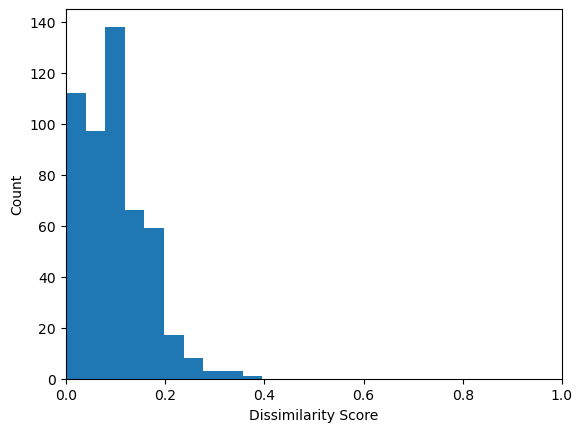

Overall Network Aged vs Young Dissimilarity Score is: 0.36999039740237644

Top 10 Dissimilar LR Pairs: ['A2m_Lrp1', 'Vim_Cd44', 'Psap_Gpr37l1', 'Apoe_Lrp8', 'Fgf2_Sdc4', 'Calr_Itga3', 'Sema6d_Tyrobp', 'Mdk_Ptprz1', 'Mdk_Itgb1', 'Timp1_Cd63']


In [18]:
dissimilarity_scores = calculate_dissim(aged_integrated, young_integrated)
plot_dissim_hist(dissimilarity_scores)
    
## Sort LR Pairs from high to low dissimilarities
print("Overall Network Aged vs Young Dissimilarity Score is: " + str(dissimilarity_score(aged_overall, young_overall)))

sorted_pairs = sorted(dissimilarity_scores, key=dissimilarity_scores.get, reverse=True)
print("\nTop 10 Dissimilar LR Pairs:", sorted_pairs[:10])

#### Plot highly dissimilar pairs between groups

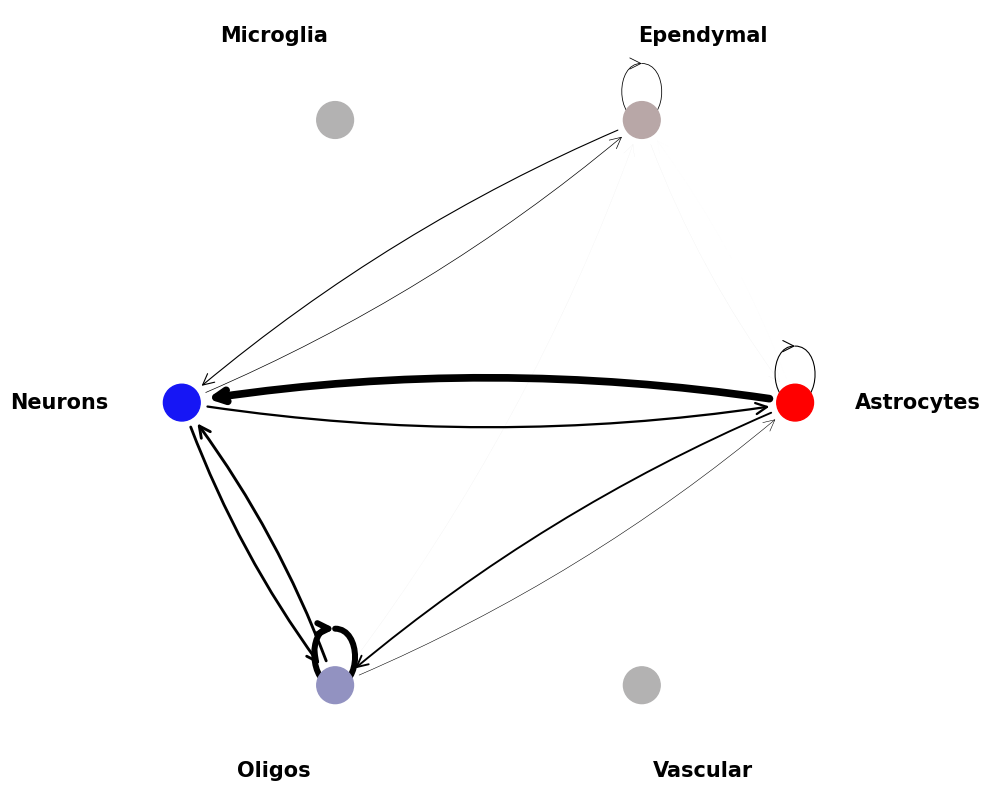

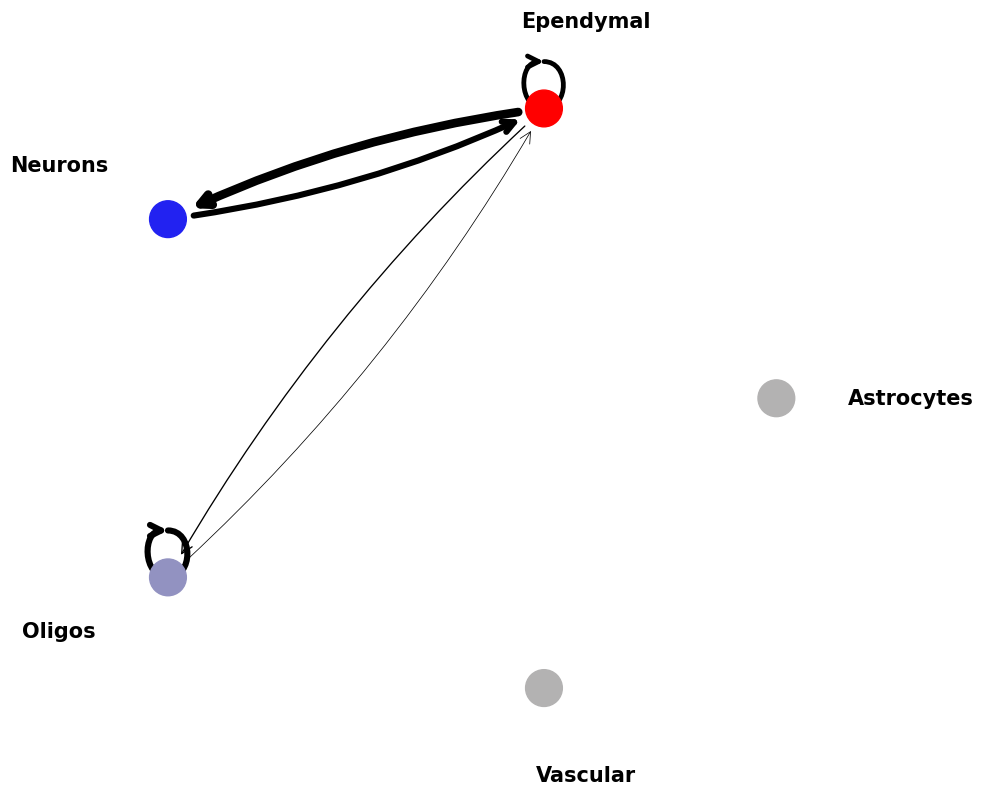

In [19]:
plot_network(aged_integrated['A2m_Lrp1'])
plot_network(young_integrated['A2m_Lrp1'])

#### Calculate p values for significance changes between groups

In [20]:
p_values = permute_and_test(aged_overall, young_overall)
p_values

,Astrocytes,Ependymal,Immune,Microglia,Neurons,Oligos,Vascular
Astrocytes,0.081435,0.386435,0.419455,0.417240,0.145165,0.233010,0.396180
Ependymal,0.387910,0.040675,0.418790,0.416525,0.151470,0.307055,0.397565
Immune,0.419140,0.419700,0.418710,0.417240,0.417325,0.419335,0.419545
Microglia,0.417700,0.419955,0.419980,0.419435,0.417370,0.420260,0.418610
Neurons,0.091005,0.153325,0.418525,0.418775,0.060855,0.132155,0.345890
Oligos,0.244825,0.284550,0.418925,0.418800,0.163125,0.009870,0.418615
Vascular,0.306745,0.399100,0.415995,0.417610,0.256920,0.419780,0.418965


#### Plot aged and young overall networks

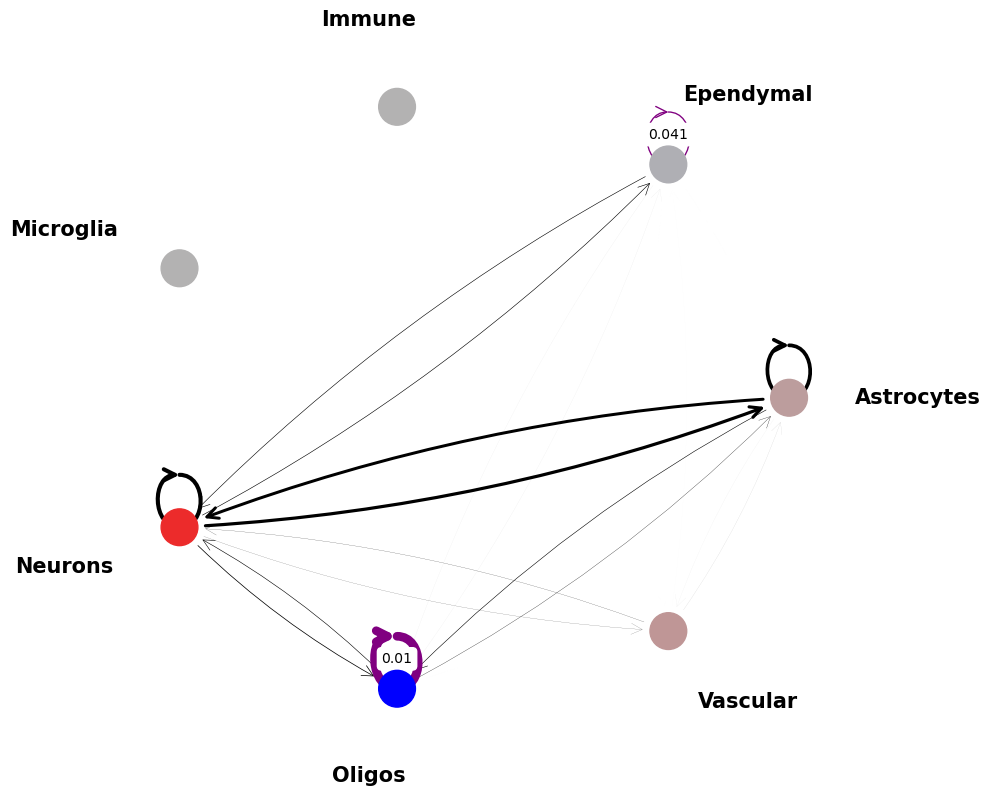

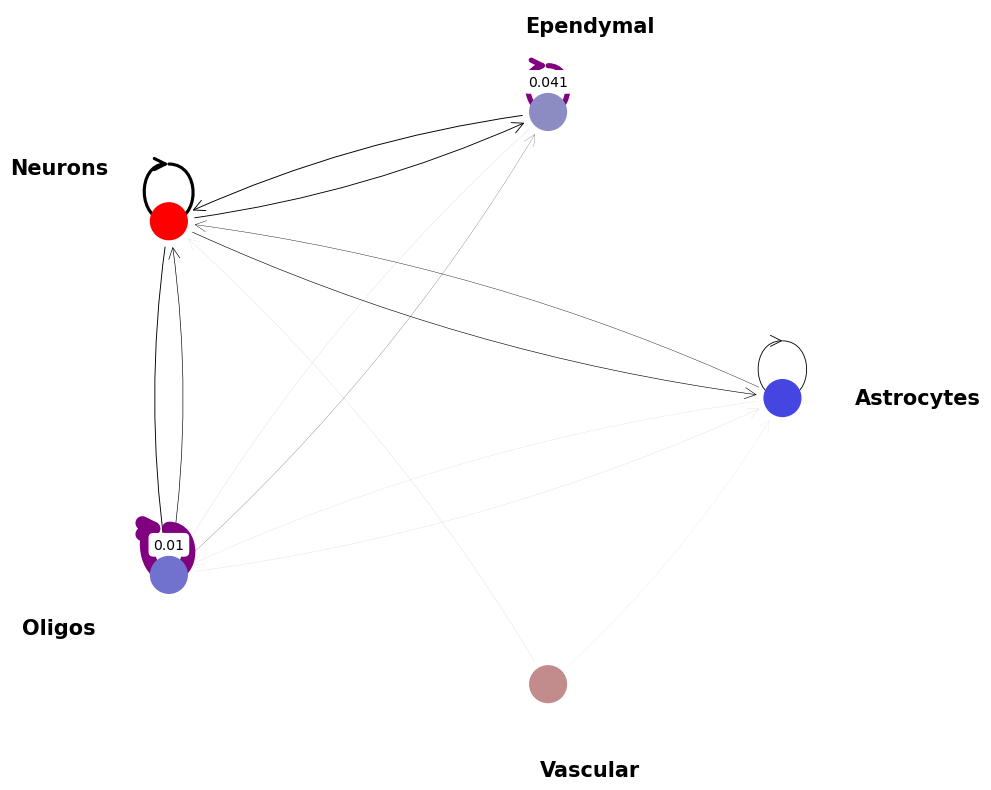

In [21]:
plot_network(aged_overall, p_values)
plot_network(young_overall, p_values)

#### Get LR pairs from Vascular to Astrocytes

In [141]:
vasc_astr_lrs = get_lrs_per_celltype([aged_integrated, young_integrated], "Vascular", "Astrocytes")
print("LR pairs from vascular to astrocytes in aged")
print(vasc_astr_lrs['sample1'])
print("\nLR pairs from vascular to astrocytes in young")
print(vasc_astr_lrs['sample2'])

LR pairs from vascular to astrocytes in aged
{'Thbs1_Cd47': 0.1538785960400883, 'Dag1_Lama4': 0.15383691011060202, 'Agrn_Dag1': 0.09980654563471869, 'Psen1_Notch3': 0.07866766273157659, 'Fbn1_Itgb1': 0.07691845505530101, 'Lama1_Itga1': 0.07347766511282776, 'Pf4_Fgfr2': 0.07008298348282242, 'Bsg_Slc16a7': 0.06508786911205076, 'Sfrp1_Fzd2': 0.0523952893956217, 'Jag2_Notch3': 0.04311337600759644, 'Col18a1_Kdr': 0.041841332089474846, 'Pdgfc_Pdgfrb': 0.04124643990124474, 'Lamb1_Itga6': 0.030236357134465198, 'Pf4_Ldlr': 0.01941051819160968}

LR pairs from vascular to astrocytes in young
{'Serpinf1_Plxdc2': 1.0}
